## Load Drive Folder

In [1]:
from google.colab import drive
drive.mount('/content/drive')
baseurl = '/content/drive/MyDrive/'

### latex
# !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
###
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(rc={'text.usetex':True, 'font.family':'sans-serif', 'font.sans-serif':'Helvetica'}, font='Helvetica')
# plt.rc('text', usetex=True)
# plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

# mpl.rc('font',**{'family':'sans-serif','sans-serif':'Helvetica'})
# from matplotlib import rc

# #rc('text', usetex=True)

Mounted at /content/drive


## Load action selection probabilities, action probabilities, posteriors


In [2]:
# Load prior and act sel probs dictionaries
with open(baseurl + 'yt_metadata_category_priors.pkl', 'rb') as f:
  priors = pickle.load(f)
with open(baseurl + 'yt_metadata_category_action_selection_probs.pkl', 'rb') as f:
  actsels = pickle.load(f)

# get an np array of priors (7 x 18) array (7 categories, 18 states)
priorkeys = [elem for elem in list(priors.keys()) if type(elem)==int]
priors_prob = np.array([priors[i] for i in  range(len(priorkeys)) ])
print('Prior array shape: ',priors_prob.shape)


# get an np array of action selection probabilities (8 categories x 18 states x 8 actions) (not 3x2**3 since some actions never arise)
actsels_prob = np.array([actsels[i] for i in  range(len(priorkeys)) ])
print('Action selection array shape: ',actsels_prob.shape)

################################################################################

# Save action probs and posterior probs
with open(baseurl + 'yt_metadata_category_act_probs.pkl', 'rb') as f:
  act_probs_by_category = pickle.load(f)
with open(baseurl + 'yt_metadata_category_posterior_probs.pkl', 'rb') as f:
  posterior_probs_by_category = pickle.load(f)

print('Action probs for categ 0 shape: ',act_probs_by_category[0].shape)
print('Posterior probs for categ 0 shape: ',posterior_probs_by_category[0].shape)

Prior array shape:  (8, 18)
Action selection array shape:  (8, 18, 8)
Action probs for categ 0 shape:  (8,)
Posterior probs for categ 0 shape:  (8, 18)


## Computing RI-AEI: NIAC with pre-specified utility, and relaxation parameter
## RI-AEI = $\arg\min_{r:r<= 1}~max(NIAC(r)) \geq 0$

In [3]:
with open(baseurl + 'yt_metadata_final_maxmargin.pkl','rb') as f:
  maxmargin_data = pickle.load(f)

with open(baseurl + 'yt_metadata_final_sparse.pkl','rb') as f:
  sparse_data = pickle.load(f)

## maybe at some point add information theoretic utility from Blahut-Arimoto algorithm ##


def NIAC_RI_AEI(relaxation, util_cost_lambda_data, pos_beliefs=posterior_probs_by_category,act_prob=act_probs_by_category,act_sels= actsels, priors = priors_prob): # check for relative optimality: for each category, does the chosen action selection policy maximize lambda*expected utility - cost
  '''
  RETURNS the max of all NIAC inequality values: max([   {exputil(p_{k'}(a|x),u_k(x,a)) - exputil(p_k(a|x),u_k(x,a)) - lambda_k (C_{k'} - C_k) } for k,k' in range(num_categs)**2 and k != k'])

  '''

  belief_shape = pos_beliefs[0].shape
  num_actions = belief_shape[0]
  num_states = belief_shape[1]
  num_categs = len(list(pos_beliefs.keys()))

  utils= []
  for categ in range(8):
    utils = utils + list(util_cost_lambda_data['utils'][categ].flatten())
    
  costs = util_cost_lambda_data['inattention_costs']
  lambdas = util_cost_lambda_data['lagrange_cost_multipliers']

  ineq_mat = []
  for categ1 in pos_beliefs.keys(): # NIAC is for a pair of categories - categ1 has higher expected utility
    for categ2 in pos_beliefs.keys():
      if categ1 != categ2:
        offset = categ1*num_states*num_actions
        exputil1 = sum([ act_prob[categ1][a]*(pos_beliefs[categ1][a,:]@utils[ offset + a*num_states: offset + (a+1)*num_states]) for a in range(num_actions) ])
        # \sum_{x,a} p_k(x|a)p_k(a)u_k(x,a)

        cross_pos_beliefs = np.zeros(pos_beliefs[0].shape)
        cross_act_probs = np.zeros((num_actions,))
        act_sel_2 = np.array(act_sels[categ2])

        for a in range(num_actions):
          cross_pos_beliefs[a,:] = priors[categ1]*np.array(act_sel_2[:,a]).reshape((num_states,))  #### (prior(x)p_{k'}(a|x))
          cross_act_probs[a] = sum(cross_pos_beliefs[a,:]) #### sum_{x} (prior(x')p_{k'}(a|x')) -- NOTE THAT: previous line is unnormalized (joint-distribution)
          cross_pos_beliefs[a,:] = cross_pos_beliefs[a,:]/cross_act_probs[a] #### (prior(x)p_{k'}(a|x))/sum_{x} (prior(x')p_{k'}(a|x'))
 
        offset = categ1*num_actions*num_states
        exputil2 = sum([ cross_act_probs[a]*max( [cross_pos_beliefs[a,:]@utils[offset + a1*num_states: offset + (a1+1)*num_states] for a1 in range(num_actions)]  ) for a in range(num_actions)])
        # \sum_{a} p_{k'}(a) (\max_{b} \sum_{x} p_{k'}(x|a) u_{k}(x,a)) - cross max utility gained by using action selection from k' in category k

        ## Debuggin blurb: print(categ1,categ2,'utils',exputil1,exputil2)
        ineq_mat.append(  exputil2 - relaxation*exputil1 - lambdas[categ1]*(costs[categ2] - costs[categ1])  )

  return max(ineq_mat)

########### COMPUTE RI-AEI FOR MAX-MARGIN AND SPARSE UTILITY ###################

sweep_range =  np.linspace(1.1,0.8,1000)
mm_aei = []
flag = 0
thresh = 0.0005
for r in sweep_range:
  relax = NIAC_RI_AEI(relaxation = r, util_cost_lambda_data = maxmargin_data)
  mm_aei.append(relax)
  if relax > thresh and flag == 0:
    mm_thresh = r
    print('RI-AEI for failing NIAC with maxmargin utility = ',r)
    flag = 1

sparse_aei = []
flag = 0
for r in sweep_range:
  relax = NIAC_RI_AEI(relaxation = r, util_cost_lambda_data = sparse_data)
  sparse_aei.append(relax)
  if relax > thresh and flag == 0:
    sparse_thresh = r
    print('RI-AEI for failing NIAC with sparse utility = ',r)
    flag = 1

RI-AEI for failing NIAC with maxmargin utility =  0.9453453453453454
RI-AEI for failing NIAC with sparse utility =  0.9912912912912913


## Plot RI-AEI for max-margin and sparsest utility

Text(0, 0.5, 'Maximum GARRI violation')

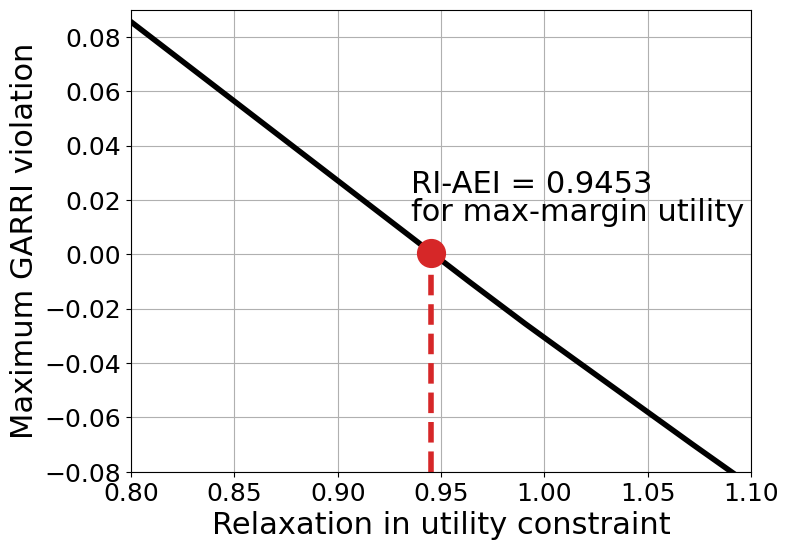

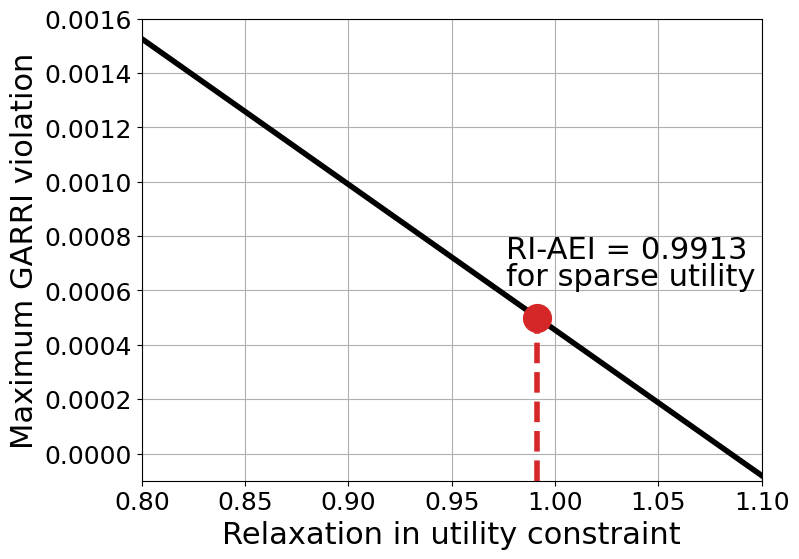

In [4]:
top = 0.09; bottom = -0.08
plt.figure(figsize=(8,6))
plt.ylim([bottom,top])
plt.xlim([sweep_range[-1],sweep_range[0]])
plt.plot(sweep_range,mm_aei, color = 'black', linewidth = 4)
markerline, stemlines, baseline = plt.stem(mm_thresh,thresh, bottom = bottom, linefmt = 'C3--', )
plt.setp(stemlines,'linewidth',4)
plt.setp(markerline,'markersize',20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.text(x=mm_thresh-0.01,y=thresh+0.022,s='RI-AEI = {:.4f}'.format(mm_thresh), fontdict = {'fontsize': 22})
plt.text(x=mm_thresh-0.01,y=thresh+0.012,s='for max-margin utility', fontdict = {'fontsize': 22})
plt.grid('on')
plt.xlabel('Relaxation in utility constraint', fontsize=22)
plt.ylabel('Maximum GARRI violation', fontsize = 22)


top = 0.0016; bottom = -0.0001
plt.figure(figsize=(8,6))
plt.ylim([bottom,top])
plt.xlim([sweep_range[-1],sweep_range[0]])
plt.plot(sweep_range,sparse_aei, color = 'black', linewidth = 4)
markerline, stemlines, baseline = plt.stem(sparse_thresh,thresh, bottom = bottom, linefmt = 'C3--', )
plt.setp(stemlines,'linewidth',4)
plt.setp(markerline,'markersize',20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.text(x=sparse_thresh-0.015,y=thresh+0.00022,s='RI-AEI = {:.4f}'.format(sparse_thresh), fontdict = {'fontsize': 22})
plt.text(x=sparse_thresh-0.015,y=thresh+0.00012,s='for sparse utility', fontdict = {'fontsize': 22})
plt.grid('on')
plt.xlabel('Relaxation in utility constraint', fontsize=22)
plt.ylabel('Maximum GARRI violation', fontsize = 22)

## Computing RI-MPI: Fix horizon size, print out absolute value of arbitrage for the horizon size (need to load disparity matrix)

In [5]:
## load discrepancy matrices for max-margin and sparse utility functions
with open(baseurl + 'yt_metadata_discrepancy_matrix_maxmargin.pkl','rb') as f:
  discrepancy_maxmargin = pickle.load(f)
with open(baseurl + 'yt_metadata_discrepancy_matrix_sparse.pkl','rb') as f:
  discrepancy_sparse = pickle.load(f)

###################### COMPUTE RI-AEI ###################################
num_categs = len(list(posterior_probs_by_category.keys()))


# if RI-MPI data exists, don't recompute,
# else, compute them all
import os

if os.path.exists(baseurl + 'yt_metadata_MPI.pkl'):
  print('RI-MPI computed, skipping computation')
else:
  print('RI-MPI not computed, computing now')
  RI_MPI_dict = {}
  
  # generate all permutations of length 2
  perm_list = []
  maxmargin_AEI = []
  sparse_AEI = []

  for i in range(num_categs):
    for j in range(num_categs):
      if i!=j:
        ind_tuple = (i,j)
        length = len(ind_tuple)
        mm_aei = sum([discrepancy_maxmargin['data'][ind_tuple[ind], ind_tuple[(ind+1)%length] ] for ind in range(length) ])/sum(discrepancy_maxmargin['expected-utilities'][ind] for ind in range(length))
        sparse_aei = sum([discrepancy_sparse['data'][ind_tuple[ind], ind_tuple[(ind+1)%length]] for ind in range(length) ])/sum(discrepancy_sparse['expected-utilities'][ind] for ind in range(length))
        perm_list.append([ind_tuple, {
            'maxmargin-AEI': mm_aei,
            'sparse-AEI': sparse_aei
        } ])
        maxmargin_AEI.append(mm_aei)
        sparse_AEI.append(sparse_aei)

  RI_MPI_dict[length] = perm_list

  print('Length = 2')
  print('Max-Margin Mean: ', np.mean(np.array(maxmargin_AEI)), ', Max-Margin Standard Deviation: ', np.std(np.array(maxmargin_AEI)) )
  print('Sparse Mean: ', np.mean(np.array(sparse_AEI)), ', Sparse Standard Deviation: ', np.std(np.array(sparse_AEI)) )
  print('Max for max-margin: ', max(maxmargin_AEI), ' Max for sparse: ', max(sparse_AEI))

  ################################################################################

  # generate all permutations of length 3
  perm_list = []
  maxmargin_AEI = []
  sparse_AEI = []

  for i in range(num_categs):
    for j in range(num_categs):
      for k in range(num_categs):
        if i!=j and j!=k and k!=i:
          ind_tuple = (i,j,k)
          length = len(ind_tuple)
          mm_aei = sum([discrepancy_maxmargin['data'][ind_tuple[ind], ind_tuple[(ind+1)%length] ] for ind in range(length) ])/sum(discrepancy_maxmargin['expected-utilities'][ind] for ind in range(length))
          sparse_aei = sum([discrepancy_sparse['data'][ind_tuple[ind], ind_tuple[(ind+1)%length]] for ind in range(length) ])/sum(discrepancy_sparse['expected-utilities'][ind] for ind in range(length))
          perm_list.append([ind_tuple, {
              'maxmargin-AEI': mm_aei,
              'sparse-AEI': sparse_aei
          } ])
          maxmargin_AEI.append(mm_aei)
          sparse_AEI.append(sparse_aei)

  RI_MPI_dict[length] = perm_list

  print('\nLength = 3')
  print('Max-Margin Mean: ', np.mean(np.array(maxmargin_AEI)), ', Max-Margin Standard Deviation: ', np.std(np.array(maxmargin_AEI)) )
  print('Sparse Mean: ', np.mean(np.array(sparse_AEI)), ', Sparse Standard Deviation: ', np.std(np.array(sparse_AEI)) )
  print('Max for max-margin: ', max(maxmargin_AEI), ' Max for sparse: ', max(sparse_AEI))

  ################################################################################

  # generate all permutations of length 4
  perm_list = []
  maxmargin_AEI = []
  sparse_AEI = []

  for i in range(num_categs):
    for j in range(num_categs):
      for k in range(num_categs):
        for l in range(num_categs):
          if i!=j and j!=k and k!=l and l!=i:
            ind_tuple = (i,j,k,l)
            length = len(ind_tuple)
            mm_aei = sum([discrepancy_maxmargin['data'][ind_tuple[ind], ind_tuple[(ind+1)%length] ] for ind in range(length) ])/sum(discrepancy_maxmargin['expected-utilities'][ind] for ind in range(length))
            sparse_aei = sum([discrepancy_sparse['data'][ind_tuple[ind], ind_tuple[(ind+1)%length]] for ind in range(length) ])/sum(discrepancy_sparse['expected-utilities'][ind] for ind in range(length))
            perm_list.append([ind_tuple, {
                'maxmargin-AEI': mm_aei,
                'sparse-AEI': sparse_aei
            } ])
            maxmargin_AEI.append(mm_aei)
            sparse_AEI.append(sparse_aei)

  RI_MPI_dict[length] = perm_list

  print('\nLength = 4')
  print('Max-Margin Mean: ', np.mean(np.array(maxmargin_AEI)), ', Max-Margin Standard Deviation: ', np.std(np.array(maxmargin_AEI)) )
  print('Sparse Mean: ', np.mean(np.array(sparse_AEI)), ', Sparse Standard Deviation: ', np.std(np.array(sparse_AEI)) )
  print('Max for max-margin: ', max(maxmargin_AEI), ' Max for sparse: ', max(sparse_AEI))

  ################################################################################

  # generate all permutations of length 5
  perm_list = []
  maxmargin_AEI = []
  sparse_AEI = []

  for i in range(num_categs):
    for j in range(num_categs):
      for k in range(num_categs):
        for l in range(num_categs):
          for m in range(num_categs):
            if i!=j and j!=k and k!=l and l!=m and m!=i:
              ind_tuple = (i,j,k,l,m)
              length = len(ind_tuple)
              mm_aei = sum([discrepancy_maxmargin['data'][ind_tuple[ind], ind_tuple[(ind+1)%length] ] for ind in range(length) ])/sum(discrepancy_maxmargin['expected-utilities'][ind] for ind in range(length))
              sparse_aei = sum([discrepancy_sparse['data'][ind_tuple[ind], ind_tuple[(ind+1)%length]] for ind in range(length) ])/sum(discrepancy_sparse['expected-utilities'][ind] for ind in range(length))
              perm_list.append([ind_tuple, {
                  'maxmargin-AEI': mm_aei,
                  'sparse-AEI': sparse_aei
              } ])
              maxmargin_AEI.append(mm_aei)
              sparse_AEI.append(sparse_aei)

  RI_MPI_dict[length] = perm_list

  print('\nLength = 5')
  print('Max-Margin Mean: ', np.mean(np.array(maxmargin_AEI)), ', Max-Margin Standard Deviation: ', np.std(np.array(maxmargin_AEI)) )
  print('Sparse Mean: ', np.mean(np.array(sparse_AEI)), ', Sparse Standard Deviation: ', np.std(np.array(sparse_AEI)))
  print('Max for max-margin: ', max(maxmargin_AEI), ' Max for sparse: ', max(sparse_AEI))

  ################################################################################

  # generate all permutations of length 6
  perm_list = []
  maxmargin_AEI = []
  sparse_AEI = []

  for i in range(num_categs):
    for j in range(num_categs):
      for k in range(num_categs):
        for l in range(num_categs):
          for m in range(num_categs):
            for n in range(num_categs):
              if i!=j and j!=k and k!=l and l!=m and m!=n and n!=i:
                ind_tuple = (i,j,k,l,m,n)
                length = len(ind_tuple)
                mm_aei = sum([discrepancy_maxmargin['data'][ind_tuple[ind], ind_tuple[(ind+1)%length] ] for ind in range(length) ])/sum(discrepancy_maxmargin['expected-utilities'][ind] for ind in range(length))
                sparse_aei = sum([discrepancy_sparse['data'][ind_tuple[ind], ind_tuple[(ind+1)%length]] for ind in range(length) ])/sum(discrepancy_sparse['expected-utilities'][ind] for ind in range(length))
                perm_list.append([ind_tuple, {
                    'maxmargin-AEI': mm_aei,
                    'sparse-AEI': sparse_aei
                } ])
                maxmargin_AEI.append(mm_aei)
                sparse_AEI.append(sparse_aei)

  RI_MPI_dict[length] = perm_list

  print('\nLength = 6')
  print('Max-Margin Mean: ', np.mean(np.array(maxmargin_AEI)), ', Max-Margin Standard Deviation: ', np.std(np.array(maxmargin_AEI)) )
  print('Sparse Mean: ', np.mean(np.array(sparse_AEI)), ', Sparse Standard Deviation: ', np.std(np.array(sparse_AEI)))
  print('Max for max-margin: ', max(maxmargin_AEI), ' Max for sparse: ', max(sparse_AEI))

  ################################################################################

  # generate all permutations of length 7
  perm_list = []
  maxmargin_AEI = []
  sparse_AEI = []

  for i in range(num_categs):
    for j in range(num_categs):
      for k in range(num_categs):
        for l in range(num_categs):
          for m in range(num_categs):
            for n in range(num_categs):
              for o in range(num_categs):
                if i!=j and j!=k and k!=l and l!=m and m!=n and n!=o and o!=i:
                  ind_tuple = (i,j,k,l,m,n,o)
                  length = len(ind_tuple)
                  mm_aei = sum([discrepancy_maxmargin['data'][ind_tuple[ind], ind_tuple[(ind+1)%length] ] for ind in range(length) ])/sum(discrepancy_maxmargin['expected-utilities'][ind] for ind in range(length))
                  sparse_aei = sum([discrepancy_sparse['data'][ind_tuple[ind], ind_tuple[(ind+1)%length]] for ind in range(length) ])/sum(discrepancy_sparse['expected-utilities'][ind] for ind in range(length))
                  perm_list.append([ind_tuple, {
                      'maxmargin-AEI': mm_aei,
                      'sparse-AEI': sparse_aei
                  } ])
                  maxmargin_AEI.append(mm_aei)
                  sparse_AEI.append(sparse_aei)

  RI_MPI_dict[length] = perm_list

  print('\nLength = 7')
  print('Max-Margin Mean: ', np.mean(np.array(maxmargin_AEI)), ', Max-Margin Standard Deviation: ', np.std(np.array(maxmargin_AEI)) )
  print('Sparse Mean: ', np.mean(np.array(sparse_AEI)), ', Sparse Standard Deviation: ', np.std(np.array(sparse_AEI)))
  print('Max for max-margin: ', max(maxmargin_AEI), ' Max for sparse: ', max(sparse_AEI))

  ################################################################################

  # generate all permutations of length 8
  perm_list = []
  maxmargin_AEI = []
  sparse_AEI = []

  for i in range(num_categs):
    for j in range(num_categs):
      for k in range(num_categs):
        for l in range(num_categs):
          for m in range(num_categs):
            for n in range(num_categs):
              for o in range(num_categs):
                for p in range(num_categs):
                  if i!=j and j!=k and k!=l and l!=m and m!=n and n!=o and o!=i:
                    ind_tuple = (i,j,k,l,m,n,o,p)
                    length = len(ind_tuple)
                    mm_aei = sum([discrepancy_maxmargin['data'][ind_tuple[ind], ind_tuple[(ind+1)%length] ] for ind in range(length) ])/sum(discrepancy_maxmargin['expected-utilities'][ind] for ind in range(length))
                    sparse_aei = sum([discrepancy_sparse['data'][ind_tuple[ind], ind_tuple[(ind+1)%length]] for ind in range(length) ])/sum(discrepancy_sparse['expected-utilities'][ind] for ind in range(length))
                    perm_list.append([ind_tuple, {
                        'maxmargin-AEI': mm_aei,
                        'sparse-AEI': sparse_aei
                    } ])
                    maxmargin_AEI.append(mm_aei)
                    sparse_AEI.append(sparse_aei)


  RI_MPI_dict[length] = perm_list

  print('\nLength = 8')
  print('Max-Margin Mean: ', np.mean(np.array(maxmargin_AEI)), ', Max-Margin Standard Deviation: ', np.std(np.array(maxmargin_AEI)) )
  print('Sparse Mean: ', np.mean(np.array(sparse_AEI)), ', Sparse Standard Deviation: ', np.std(np.array(sparse_AEI)))
  print('Max for max-margin: ', max(maxmargin_AEI), ' Max for sparse: ', max(sparse_AEI))

  with open(baseurl + 'yt_metadata_MPI.pkl','wb') as f:
    pickle.dump(RI_MPI_dict,f, protocol = pickle.HIGHEST_PROTOCOL)


RI-MPI computed, skipping computation


## Computing RI - Minimum Perturbation Test (Varian number) - need to compute action selection probability perturbations.

In [6]:
# FOR MAX-MARGIN DATA #

## add pert (of shape (num_categs,num_states,num_actions)) to act_sel_probs and then return negative of max(NIAS,NIAC)
def max_NIAC_NIAC_MPT_maxmargin(perts,actsels_prob = actsels_prob, priors_prob = priors_prob, data = maxmargin_data):
  '''
  RETURNS: negative of max value of all NIAS and NIAC inequalities
  MPT computation: aim to maximize the returned value and plot against magnitude of allowed
  perturbations in the action selection policies
  '''
  ineq_list = []

  (num_categs,num_states,num_actions) = actsels_prob.shape
  mod_actsels_prob = np.zeros(actsels_prob.shape) # modified action selection probabilities

  for categ in range(num_categs):
    for state in range(num_states):
      for action in range(num_actions):
        mod_actsels_prob[categ,state,action] = actsels_prob[categ,state,action] + perts[categ*num_states*num_actions + state*num_actions + action] # perturb the action selection policy with the perts vector

  
  pos_beliefs = {} # compute posterior beliefs, and act probs for modified action selection probabilities
  act_prob = {}
  # turn perturbed action selection probabilities to posterior probabilities
  for categ in range(num_categs): # parametrizes the prior
    act_prob[categ] = []
    pos_beliefs[categ] = []
    for action in range(num_actions):
      # compute p(a) = prior*p(a|x)
      act_prob[categ].append(priors_prob[categ,:]@mod_actsels_prob[categ,:,action])
      # compute p(x|a) = p(a|x)*prior/p(a)
      pos_beliefs[categ].append(mod_actsels_prob[categ,:,action]*priors_prob[categ,:]/(mod_actsels_prob[categ,:,action]@priors_prob[categ,:]))

    pos_beliefs[categ] = np.array(pos_beliefs[categ]) 

  ### unwrap utils, costs, lagrange multipliers
  utils= []
  for categ in range(num_categs):
    utils = utils + list(data['utils'][categ].flatten())
    
  utils = np.array(utils)
  costs = data['inattention_costs']
  lambdas = data['lagrange_cost_multipliers']

  ######### NIAS ##########

  for categ in pos_beliefs.keys(): # NIAS for every category
    for a in range(num_actions): # NIAS for every action in every category
      for b in range(num_actions): # NIAS (compare optimal action a to every non-optimal action b for every category)
        if a!=b:
          ## every element must be less than 0 for NIAS to go through   
          ## \sum_{x} p(x|a)*( u(x,b) - u(x,a) ) <= 0
          offset_a = categ*num_states*num_actions + a*num_states
          offset_b = categ*num_states*num_actions + b*num_states

          ineq_list.append(pos_beliefs[categ][a,:]@np.array(utils[offset_b: offset_b + num_states] - utils[offset_a: offset_a + num_states]) )

  ######### NIAC ##########

  for categ1 in pos_beliefs.keys(): # NIAC is for a pair of categories - categ1 has higher expected utility
    for categ2 in pos_beliefs.keys():
      if categ1 != categ2:
        offset = categ1*num_states*num_actions
        exputil1 = sum([ act_prob[categ1][a]*(pos_beliefs[categ1][a,:]@utils[ offset + a*num_states: offset + (a+1)*num_states]) for a in range(num_actions) ])
        # \sum_{x,a} p_k(x|a)p_k(a)u_k(x,a)

        cross_pos_beliefs = np.zeros(pos_beliefs[0].shape)
        cross_act_probs = np.zeros((num_actions,))
        act_sel_2 = np.array(mod_actsels_prob[categ2,:,:])

        for a in range(num_actions):
          cross_pos_beliefs[a,:] = priors_prob[categ1,:]*np.array(act_sel_2[:,a]).reshape((num_states,))  #### (prior(x)p_{k'}(a|x))
          cross_act_probs[a] = sum(cross_pos_beliefs[a,:]) #### sum_{x} (prior(x')p_{k'}(a|x')) -- NOTE THAT: previous line is unnormalized (joint-distribution)
          cross_pos_beliefs[a,:] = cross_pos_beliefs[a,:]/cross_act_probs[a] #### (prior(x)p_{k'}(a|x))/sum_{x} (prior(x')p_{k'}(a|x'))
 
        offset = categ1*num_actions*num_states
        exputil2 = sum([ cross_act_probs[a]*max( [cross_pos_beliefs[a,:]@utils[offset + a1*num_states: offset + (a1+1)*num_states] for a1 in range(num_actions)]  ) for a in range(num_actions)])
        # \sum_{a} p_{k'}(a) (\max_{b} \sum_{x} p_{k'}(x|a) u_{k}(x,a)) - cross max utility gained by using action selection from k' in category k

        ## Debuggin blurb: print(categ1,categ2,'utils',exputil1,exputil2)
        ineq_list.append(  exputil2 - exputil1 - lambdas[categ1]*(costs[categ2] - costs[categ1])  )
  return -max(ineq_list)

### sanity check #### zeros pert vector must yield a positive value (since NIAS, NIAC <= 0 for all ineqs, hence max is -ve, hence -ve of max => positive)
sanity = max_NIAC_NIAC_MPT_maxmargin(perts = np.array([0]*(8*8*18)))
print('Negative of max of NIAS/NIAC = ', sanity, ', Sanity Check Pass for max-margin data = ', 'Yes!!' if sanity>-0.0005 else 'No :/' )
print('-------------------------------\n')

################################################################################
################################################################################
################################################################################

# FOR SPARSE DATA #

## add pert (of shape (num_categs,num_states,num_actions)) to act_sel_probs and then return negative of max(NIAS,NIAC)
def max_NIAC_NIAC_MPT_sparse(perts,actsels_prob = actsels_prob, priors_prob = priors_prob, data = sparse_data):
  '''
  RETURNS: negative of max value of all NIAS and NIAC inequalities
  MPT computation: aim to maximize the returned value and plot against magnitude of allowed
  perturbations in the action selection policies
  '''
  ineq_list = []

  (num_categs,num_states,num_actions) = actsels_prob.shape
  mod_actsels_prob = np.zeros(actsels_prob.shape) # modified action selection probabilities

  for categ in range(num_categs):
    for state in range(num_states):
      for action in range(num_actions):
        mod_actsels_prob[categ,state,action] = actsels_prob[categ,state,action] + perts[categ*num_states*num_actions + state*num_actions + action] # perturb the action selection policy with the perts vector

  
  pos_beliefs = {} # compute posterior beliefs, and act probs for modified action selection probabilities
  act_prob = {}
  # turn perturbed action selection probabilities to posterior probabilities
  for categ in range(num_categs): # parametrizes the prior
    act_prob[categ] = []
    pos_beliefs[categ] = []
    for action in range(num_actions):
      # compute p(a) = prior*p(a|x)
      act_prob[categ].append(priors_prob[categ,:]@mod_actsels_prob[categ,:,action])
      # compute p(x|a) = p(a|x)*prior/p(a)
      pos_beliefs[categ].append(mod_actsels_prob[categ,:,action]*priors_prob[categ,:]/(mod_actsels_prob[categ,:,action]@priors_prob[categ,:]))

    pos_beliefs[categ] = np.array(pos_beliefs[categ]) 

  ### unwrap utils, costs, lagrange multipliers
  utils= []
  for categ in range(num_categs):
    utils = utils + list(data['utils'][categ].flatten())
    
  utils = np.array(utils)
  costs = data['inattention_costs']
  lambdas = data['lagrange_cost_multipliers']

  ######### NIAS ##########

  for categ in pos_beliefs.keys(): # NIAS for every category
    for a in range(num_actions): # NIAS for every action in every category
      for b in range(num_actions): # NIAS (compare optimal action a to every non-optimal action b for every category)
        if a!=b:
          ## every element must be less than 0 for NIAS to go through   
          ## \sum_{x} p(x|a)*( u(x,b) - u(x,a) ) <= 0
          offset_a = categ*num_states*num_actions + a*num_states
          offset_b = categ*num_states*num_actions + b*num_states

          ineq_list.append(pos_beliefs[categ][a,:]@np.array(utils[offset_b: offset_b + num_states] - utils[offset_a: offset_a + num_states]) )

  ######### NIAC ##########

  for categ1 in pos_beliefs.keys(): # NIAC is for a pair of categories - categ1 has higher expected utility
    for categ2 in pos_beliefs.keys():
      if categ1 != categ2:
        offset = categ1*num_states*num_actions
        exputil1 = sum([ act_prob[categ1][a]*(pos_beliefs[categ1][a,:]@utils[ offset + a*num_states: offset + (a+1)*num_states]) for a in range(num_actions) ])
        # \sum_{x,a} p_k(x|a)p_k(a)u_k(x,a)

        cross_pos_beliefs = np.zeros(pos_beliefs[0].shape)
        cross_act_probs = np.zeros((num_actions,))
        act_sel_2 = np.array(mod_actsels_prob[categ2,:,:])

        for a in range(num_actions):
          cross_pos_beliefs[a,:] = priors_prob[categ1,:]*np.array(act_sel_2[:,a]).reshape((num_states,))  #### (prior(x)p_{k'}(a|x))
          cross_act_probs[a] = sum(cross_pos_beliefs[a,:]) #### sum_{x} (prior(x')p_{k'}(a|x')) -- NOTE THAT: previous line is unnormalized (joint-distribution)
          cross_pos_beliefs[a,:] = cross_pos_beliefs[a,:]/cross_act_probs[a] #### (prior(x)p_{k'}(a|x))/sum_{x} (prior(x')p_{k'}(a|x'))
 
        offset = categ1*num_actions*num_states
        exputil2 = sum([ cross_act_probs[a]*max( [cross_pos_beliefs[a,:]@utils[offset + a1*num_states: offset + (a1+1)*num_states] for a1 in range(num_actions)]  ) for a in range(num_actions)])
        # \sum_{a} p_{k'}(a) (\max_{b} \sum_{x} p_{k'}(x|a) u_{k}(x,a)) - cross max utility gained by using action selection from k' in category k

        ## Debuggin blurb: print(categ1,categ2,'utils',exputil1,exputil2)
        ineq_list.append(  exputil2 - exputil1 - lambdas[categ1]*(costs[categ2] - costs[categ1])  )
  return -max(ineq_list)

### sanity check #### zeros pert vector must yield a positive value (since NIAS, NIAC <= 0 for all ineqs, hence max is -ve, hence -ve of max => positive)
sanity = max_NIAC_NIAC_MPT_sparse(perts = np.array([0]*(8*8*18)))
print('Negative of max of NIAS/NIAC = ', sanity, ', Sanity Check Pass for sparse data = ', 'Yes!!' if sanity> -0.0005 else 'No :/' )
print('-------------------------------\n')

################################################################################
################################################################################
################################################################################
################################################################################

## compute set of linear inequalities for the perturbations

def pert_act_sel_constraints(act_sels = actsels_prob):
  '''
  RETURNS: a set of linear constraints with lower and upper bounds for a perturbation 
  vector to be a valid perturbation vector, that is, when added to a valid action
  selection matrix, the result should still be a valid action selection matrix.
  Two constraints are encoded: (1) \sum_{a} p_k(a|x) + pert_k(a|x) = 0 for all x,k, 
  and (2) p_k(a|x) + pert_k(a|x) must be within [0,1]
  '''

  (num_categs, num_states, num_actions) = actsels_prob.shape
  num_vars = num_categs*num_actions*num_states

  ineq_mat = np.zeros((num_categs*num_states + num_vars,num_vars))
  # for all categs and states, sum must be zero
  # for all categ, state, action: 0 <= p_k(a|x) + pert_k(a,x) <= 1
  lb = (-0.00001)*np.ones((num_categs*num_states + num_vars,))
  ub = (+0.00001)*np.ones((num_categs*num_states + num_vars,))

  count = 0
  for categ in range(num_categs):
    for state in range(num_states):
      ineq_mat[count,categ*num_states*num_actions + state*num_actions:categ*num_states*num_actions + (state+1)*num_actions] = 1 # upper and lower bound with +/- thresh (since sum must be zero)
      count = count + 1

  for categ in range(num_categs):
    for state in range(num_states):
      for action in range(num_actions):
        ineq_mat[count, (categ*num_states + state)*num_actions + action] = 1
        # upper and lower bound by 1-p_k(a|x), -p_k(a|x), respectively
        lb[count] = -act_sels[categ,state, action]
        ub[count] = 1 - act_sels[categ,state, action]
        count = count + 1

  return ineq_mat,lb,ub
    

## objective: minimize returned value of max_NIAS_NIAC_MPT(...), subject to linear constraint from pert_act_sel_constraints(...)

from scipy.optimize import minimize, NonlinearConstraint, LinearConstraint, Bounds

belief_shape = posterior_probs_by_category[0].shape
num_actions = belief_shape[0]
num_states = belief_shape[1]
num_categs = len(list(posterior_probs_by_category.keys()))


def avg_magnitude(perts): # to constraint the sum of perturbation magnitudes and sweep over the sum.
  return np.sqrt(sum(perts**2))/len(perts)

lin_ineq_mat, lin_ineq_lb, lin_ineq_ub = pert_act_sel_constraints()
bounds = Bounds([(-np.inf,np.inf)]*(num_categs*num_states*num_actions))


pert_mag_sweep = np.logspace(-6,-1,20) # sweep range


##### PROXY FOR MULTIPLE RUNS ##### 
##### UNCOMMENT AND RUN THIS BLOCK BELOW IF YOU HAVE GOOD COMPUTE #####
##### IN WHICH CASE NO NEED TO RUN NEXT BLOCK #####

# max_constraint_violation_maxmargin = []
# max_constraint_violation_sparse = []

# for pert_mag_thresh in pert_mag_sweep:
#   print('\nAllowed perturbation threshold = ',pert_mag_thresh)

#   # #### TAKES A LOT OF TIME ####

#   ##### for max-margin #####
#   opt_pert = minimize(fun = max_NIAC_NIAC_MPT_maxmargin,
#                       x0 = pert_mag_thresh*np.ones((num_categs*num_actions*num_states,)),
#                       bounds =  [(-1,1)]*(num_categs*num_states*num_actions), # no constraints
#                       constraints = (LinearConstraint(lin_ineq_mat, lin_ineq_lb, lin_ineq_ub), NonlinearConstraint(avg_magnitude, 0, pert_mag_thresh),),
#                       options = {'disp': True}
#                       )
#   print('--- Negative of Max value of NIAS/NIAC for maxmargin  = ', opt_pert.fun,' -----')
#   print('--- Argmin for max-margin  = ', opt_pert.x)
#   max_constraint_violation_maxmargin.append(opt_pert.fun) # append max value of NIAS and NIAC

#   ##### for sparse #####
#   opt_pert = minimize(fun = max_NIAC_NIAC_MPT_sparse,
#                       x0 = pert_mag_thresh*np.ones((num_categs*num_actions*num_states,)),
#                       bounds =  [(-1,1)]*(num_categs*num_states*num_actions), # no constraints
#                       constraints = (LinearConstraint(lin_ineq_mat, lin_ineq_lb, lin_ineq_ub), NonlinearConstraint(avg_magnitude, 0, pert_mag_thresh),),
#                       options = {'disp': True}
#                       )
#   print('--- Negative of Max value of NIAS/NIAC for sparse  = ', opt_pert.fun,' -----')
#   print('--- Argmin of sparse  = ', opt_pert.x)
#   max_constraint_violation_sparse.append(opt_pert.fun) # append max value of NIAS and NIAC

#   ## save both lists
#   with open(baseurl + 'ri-mpt-maxmargin-sparse.pkl','wb') as f:
#     pickle.dump({
#         'avg_sqrd_mag_sweep_range':pert_mag_sweep,
#         'max_constraint_violation_maxmargin':max_constraint_violation_maxmargin,
#         'max_constraint_violation_sparse':max_constraint_violation_sparse
#     },f)

Negative of max of NIAS/NIAC =  0.014917896424004096 , Sanity Check Pass for max-margin data =  Yes!!
-------------------------------

Negative of max of NIAS/NIAC =  -0.0004546072851087695 , Sanity Check Pass for sparse data =  Yes!!
-------------------------------



## Open up existing list of optimal perturbationsIf list is not yet complete, make one run

In [7]:
with open(baseurl + 'ri-mpt-maxmargin-sparse.pkl','rb') as f:
  ri_mpt_dict = pickle.load(f)

print(ri_mpt_dict)

################################################################################

current_iter = len(ri_mpt_dict['max_constraint_violation_maxmargin'])

if current_iter < len(pert_mag_sweep):
  pert_mag_thresh = pert_mag_sweep[current_iter]
  print('\n Allowed perturbation threshold = ', pert_mag_thresh)

  # #### TAKES A LOT OF TIME ####

  ##### for max-margin #####
  opt_pert = minimize(fun = max_NIAC_NIAC_MPT_maxmargin,
                      x0 = pert_mag_thresh*np.ones((num_categs*num_actions*num_states,)),
                      bounds =  [(-1,1)]*(num_categs*num_states*num_actions), # no constraints
                      constraints = (LinearConstraint(lin_ineq_mat, lin_ineq_lb, lin_ineq_ub), NonlinearConstraint(avg_magnitude, 0, pert_mag_thresh),),
                      options = {'disp': True}
                      )
  print('--- Negative of Max value of NIAS/NIAC for maxmargin  = ', opt_pert.fun,' -----')
  print('--- Argmin for max-margin  = ', opt_pert.x)
  ri_mpt_dict['max_constraint_violation_maxmargin'].append(opt_pert.fun) # append max value of NIAS and NIAC

  ##### for sparse #####
  opt_pert = minimize(fun = max_NIAC_NIAC_MPT_sparse,
                      x0 = pert_mag_thresh*np.ones((num_categs*num_actions*num_states,)),
                      bounds =  [(-1,1)]*(num_categs*num_states*num_actions), # no constraints
                      constraints = (LinearConstraint(lin_ineq_mat, lin_ineq_lb, lin_ineq_ub), NonlinearConstraint(avg_magnitude, 0, pert_mag_thresh),),
                      options = {'disp': True}
                      )
  print('--- Negative of Max value of NIAS/NIAC for sparse  = ', opt_pert.fun,' -----')
  print('--- Argmin of sparse  = ', opt_pert.x)
  ri_mpt_dict['max_constraint_violation_sparse'].append(opt_pert.fun) # append max value of NIAS and NIAC

  ## save both lists
  with open(baseurl + 'ri-mpt-maxmargin-sparse.pkl','wb') as f:
    pickle.dump(ri_mpt_dict,f)

## Ensure that the final plottables need to be normalized by the maximum utility value to be comparable ##
########################################################################################################

{'avg_sqrd_mag_sweep_range': array([1.00000000e-06, 1.83298071e-06, 3.35981829e-06, 6.15848211e-06,
       1.12883789e-05, 2.06913808e-05, 3.79269019e-05, 6.95192796e-05,
       1.27427499e-04, 2.33572147e-04, 4.28133240e-04, 7.84759970e-04,
       1.43844989e-03, 2.63665090e-03, 4.83293024e-03, 8.85866790e-03,
       1.62377674e-02, 2.97635144e-02, 5.45559478e-02, 1.00000000e-01]), 'max_constraint_violation_maxmargin': [0.010035479620505994, 0.00842206142316497, 0.0019683886338008744, -0.008829185909214408, -0.02812950000652485, -0.06399592517193747, -0.1308730019796637, -0.26205898567926744, -0.5846265514592518, -0.5958748999293279, -0.6555253481188268, -0.6555253539440784, -0.8022484764293303, -0.8022484799196752, -0.8022484804433487, -0.9956894523344405, -0.9956894523345939, -0.9985948762438246, -0.9985949377910384, -0.9985951001269694], 'max_constraint_violation_sparse': [-0.000459965662525269, -0.00046434318083364427, -0.000472367298220587, -0.0004870771014080349, -0.000514037088

## Normalize wrt max utility for each of the max-margin, and sparse utilities
## Max of maxmargin utils = 1, need to find max of sparse utils for normalization

In [8]:
with open(baseurl + 'yt_metadata_final_sparse.pkl','rb') as f:
  sparse_data = pickle.load(f)

max_util = []
for categ in sparse_data['utils'].keys():
  if type(categ) == int:
    max_util.append(max(sparse_data['utils'][categ].flatten()))

max_util = max(max_util)
max_util

0.05608946950042733

## Visualization of MPT for max-margin and sparse normalized

Text(0, 0.5, 'Maximum normalized constraint\nviolation for NIAS and GARRI')

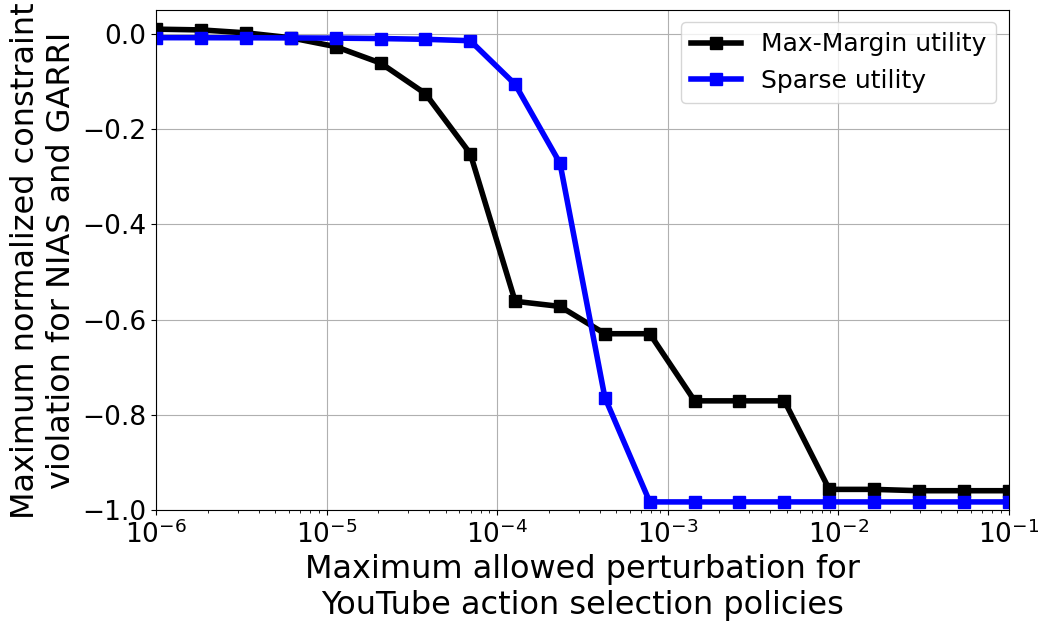

In [28]:
import matplotlib

plt.figure(figsize = (11,6.5))
plt.plot(pert_mag_sweep,[0.96*elem for elem in ri_mpt_dict['max_constraint_violation_maxmargin']], linewidth = 4, color = 'black', marker = "s", markersize = 8)
plt.plot(pert_mag_sweep,[(1/max_util)*elem for elem in ri_mpt_dict['max_constraint_violation_sparse']], linewidth = 4, color = 'blue', marker = "s", markersize = 8)
plt.xscale('log')
plt.grid('on')
plt.legend(['Max-Margin utility','Sparse utility'],prop={'size': 18})
plt.xticks(fontsize = 19)
plt.yticks(fontsize = 19)
plt.ylim([-1,0.05])
plt.xlim(pert_mag_sweep[0],pert_mag_sweep[-1])
plt.xlabel('Maximum allowed perturbation for\nYouTube action selection policies',fontdict={'fontsize':23})
plt.ylabel('Maximum normalized constraint\nviolation for NIAS and GARRI', fontdict={'fontsize':23})